# Local background estimation

`opticam_new` supports specification of local background estimators, which can improve the background estimation in cases where the background varies considerably across an image. In this notebook, I will demonstrate how to define a local background estimator for use with `opticam_new`, as well as explain `opticam_new`'s default local background estimator.

## Generating Data

First thing's first, we need to generate some dummy data:

In [1]:
import opticam_new

opticam_new.generate_observations(
    out_dir='local_backgrounds_tutorial/data',
    n_images=20,
    circular_aperture=False,
    )

[OPTICAM] variable source is at (122, 104)


Generating observations: 100%|██████████|[00:04<00:00]


Now we can use these dummy observations to compute and compare local backgrounds.

## Generating Catalogs

Before we can look at the local background estimator, we need to create our source catalogs:

[OPTICAM] local_backgrounds_tutorial/reduced not found, attempting to create ...
[OPTICAM] local_backgrounds_tutorial/reduced created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]

[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


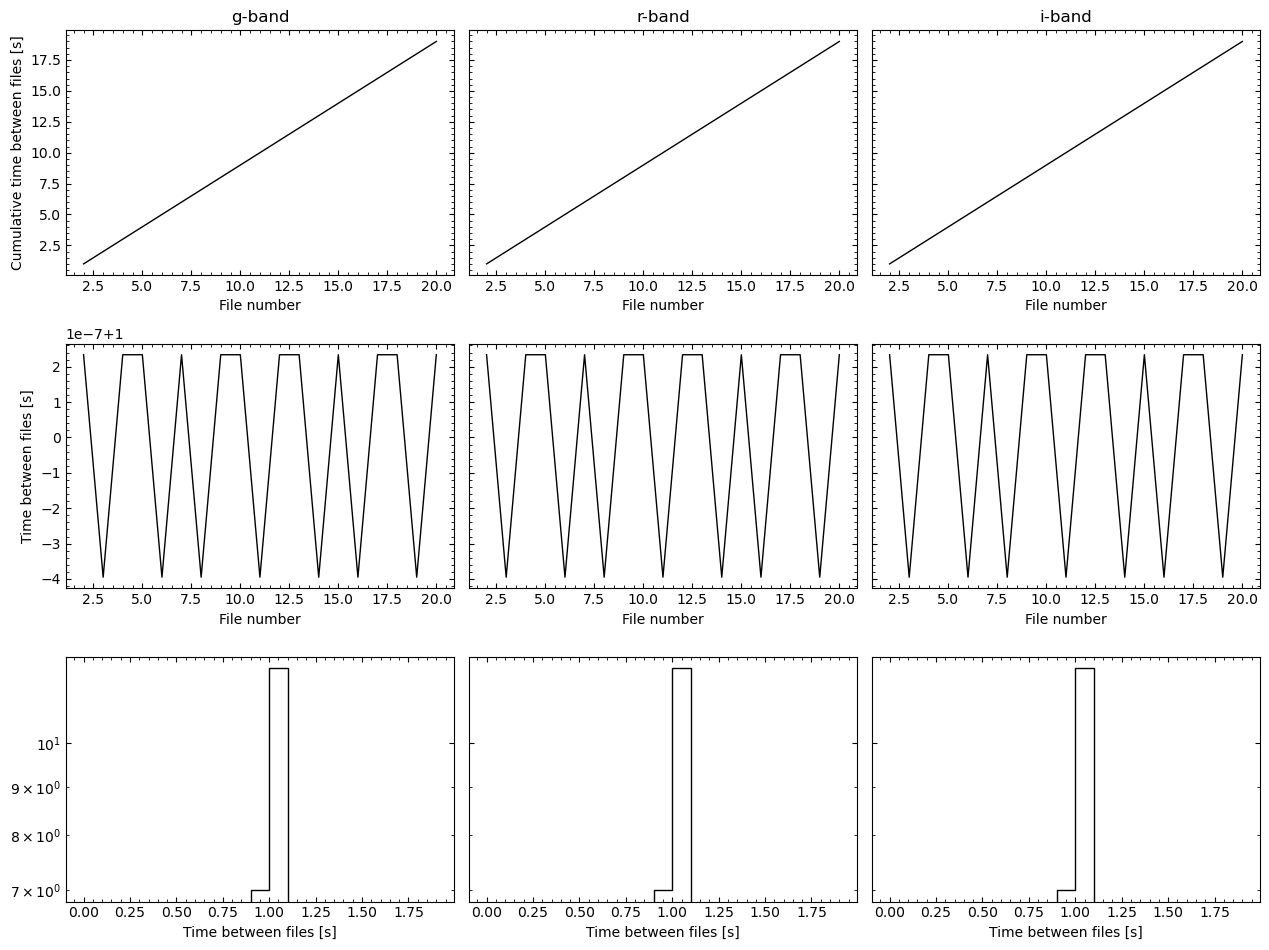

In [2]:
cat = opticam_new.Catalog(
    data_directory='local_backgrounds_tutorial/data',
    out_directory='local_backgrounds_tutorial/reduced',
    remove_cosmic_rays=False,
    )

[OPTICAM] Initialising catalogs


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


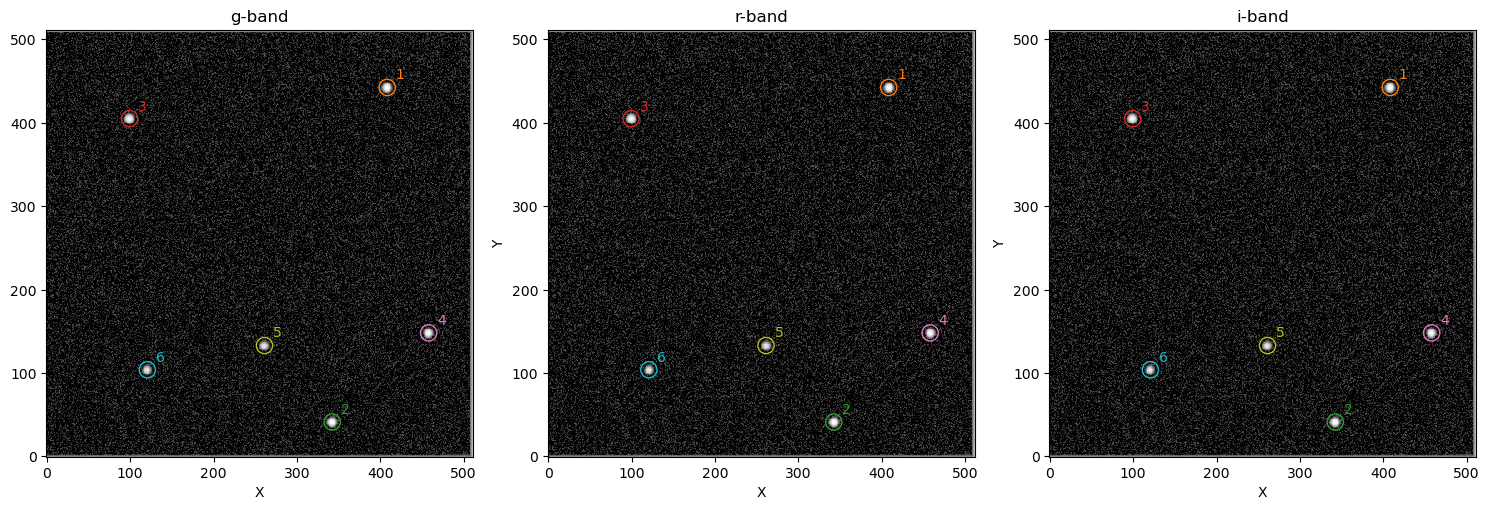

In [3]:
cat.create_catalogs()

## `DefaultLocalBackground`

Now we look at the default local background estimator, `DefaultLocalBackground`. The default local background estimator uses an elliptical annulus that scales the `semimajor_sigma` and `semiminor_sigma` parameters of the catalogue's `psf_params` dictionary. Let's see what this dictionary looks like:

In [5]:
cat.psf_params

{'g-band': {'semimajor_sigma': np.float64(1.947867010701578),
  'semiminor_sigma': np.float64(1.9362408131678852),
  'orientation': np.float64(47.13371883619817)},
 'r-band': {'semimajor_sigma': np.float64(1.9478670106350826),
  'semiminor_sigma': np.float64(1.9362408131119144),
  'orientation': np.float64(47.152263419301484)},
 'i-band': {'semimajor_sigma': np.float64(1.9478670107825269),
  'semiminor_sigma': np.float64(1.936240813226689),
  'orientation': np.float64(47.17119043872118)}}

We can see that all three cameras have the same PSF parameters, since these simulated data are the same for each camera. In practise, the PSF parameters will generally be different between cameras. 

We can see each camera has three PSF parameters:
- `semimajor_sigma`: the standard deviation of the PSF along the semi-major axis (assuming a 2D Gaussian PSF)
- `semiminor_sigma`: the standard deviation of the PSF along the semi-minor axis (assuming a 2D Gaussian PSF)
- `orientation`: the orientation of the PSF in degrees

When defining a custom local background estimator, it's a good idea to use these values to define your annulus (more on this later). For now, let's perform photometry using the default local background estimator:

In [6]:
phot = opticam_new.OptimalPhotometer(
    local_background_estimator=opticam_new.DefaultLocalBackground(),
)

cat.photometry(phot)

[OPTICAM] Photometry results will be saved to optimal_annulus_light_curves in local_backgrounds_tutorial/reduced.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]


Let's take a look at the resulting light curve file for a random source:

In [7]:
import pandas as pd

default_g_band_source_2_df = pd.read_csv(
    'local_backgrounds_tutorial/reduced/optimal_annulus_light_curves/g-band_source_2.csv',
    )

default_g_band_source_2_df

,flux,flux_err,background,background_err,BMJD
0,432.999425,10.673493,100.541360,9.986540,60310.000000
1,433.165506,10.905346,98.669093,10.235830,60310.000012
2,431.942271,10.963515,100.166224,10.298477,60310.000023
3,431.465017,9.964454,99.602199,9.228097,60310.000035
4,434.025681,10.709357,101.071948,10.023068,60310.000046
5,432.006028,10.339840,99.736465,9.632121,60310.000058
6,429.911557,10.072193,100.981359,9.345138,60310.000069
7,431.166918,10.540508,100.106304,9.848330,60310.000081
8,431.436103,10.140895,99.966898,9.418578,60310.000093
9,429.945455,11.011182,101.971043,10.348042,60310.000104


We can see that the light curve file has background and background_err columns, which are only included if a local background estimator was used to compute the light curve. The average background is about 100, which is the expected value, and the average background error is about $\sqrt{100} = 10$, which is also the expected value, showing that the default local background estimator is working well.

## Custom Local Background

The default local background estimator uses the mean and standard deviation in the sigma-clipped annulus to estimate the background and its error, respectively. We will therefore define a custom local background estimator that works slightly differently, using the median instead of the mean, and the median absolute deviation instead of the standard deviation. 

To define a custom local background estimator, you should either inherit from the `BaseLocalBackground` base class, or define a class that implements a `__call__()` method with the following input parameters:
- `data`: the image data as a 2D `numpy` array
- `error`: the error in the image data as a 2D `numpy` array
- `position`: the position of a source as a tuple (x, y)
- `semimajor_axis`: the semi-major standard deviation of the PSF (assumed to be a 2D Gaussian)
- `semiminor_axis`: the semi-minor standard deviation of the PSF (assumed to be a 2D Gaussian)
- `orientation`: the orientation of the PSF in degrees

For simplicity, I will inherit from the base class since this is how I'd recommend defining a custom local background estimator:

In [9]:
from opticam_new.reduction.local_background import BaseLocalBackground

from photutils.aperture import EllipticalAnnulus, ApertureStats

class CustomLocalBackground(BaseLocalBackground):
    
    def __call__(
        self,
        data,  # the image data as a 2D numpy array
        error,  # the error in the image data as a 2D numpy array
        position,  # the position of a source as a tuple (x, y)
        semimajor_axis,  # the semimajor axis of the PSF in pixels (assuming a 2D Gaussian PSF)
        semiminor_axis,  # the semiminor axis of the PSF in pixels (assuming a 2D Gaussian PSF)
        orientation,  # the orientation of the PSF in degrees
        ):
        
        # define the annulus using photutils
        annulus = EllipticalAnnulus(
            positions=position,
            a_in=self.r_in_scale * semimajor_axis,
            a_out=self.r_out_scale * semimajor_axis,
            b_in=self.r_in_scale * semiminor_axis,
            b_out=self.r_out_scale * semiminor_axis,
            theta=orientation,
        )
        
        # compute the statistics in the annulus
        stats = ApertureStats(
            data,
            annulus,
            error=error,
            sigma_clip=self.sigma_clip,
        )
        
        median_local_background = float(stats.median)
        
        # median absolute deviation (MAD) of the local background
        mad_std_local_background = float(stats.mad_std)
        
        return median_local_background, mad_std_local_background

When inheriting from the `BaseLocalBackground` base class, there is no need to implement an `__init__()` method.

The order of the parameters in the `__call__()` method is important, since `opticam_new`'s photometry routines assume a local background estimator's `__call__()` method takes the above parameters in the above order. These parameters are handled by the catalogue, and so you don't need to worry about computing them. In particular, the `semimajor_axis`, `semiminor_axis`, and `orientation` parameters are passed from the catalogue's `psf_params` dictionary using the appropriate values for the camera corresponding to the image, so you don't need to worry about unpacking this dictionary.

Finally, there is no requirement to use `photutils` for estimating local backgrounds, but `photutils` does make it a lot easier.

Let's now perform photometry using our custom local background estimator:

In [10]:
from astropy.stats import SigmaClip

custom_phot = opticam_new.OptimalPhotometer(
    local_background_estimator=CustomLocalBackground(
        r_in_scale=5,
        r_out_scale=6,
        sigma_clip=SigmaClip(
            sigma=3,
            maxiters=10,
            ),
        ),
)

cat.photometry(custom_phot)

[OPTICAM] Photometry results will be saved to optimal_annulus_light_curves in local_backgrounds_tutorial/reduced.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]


In [11]:
custom_g_band_source_2_df = pd.read_csv(
    'local_backgrounds_tutorial/reduced/optimal_annulus_light_curves/g-band_source_2.csv',
    )

custom_g_band_source_2_df

,flux,flux_err,background,background_err,BMJD
0,431.851133,11.442116,101.689652,10.804145,60310.000000
1,434.001516,10.229813,97.833082,9.512871,60310.000012
2,431.630545,10.741558,100.477951,10.061861,60310.000023
3,431.275066,9.604017,99.792150,8.837679,60310.000035
4,434.935973,9.908621,100.161657,9.162550,60310.000046
5,432.821894,10.756675,98.920598,10.078270,60310.000058
6,430.910770,10.220638,99.982146,9.504944,60310.000069
7,430.927339,11.450960,100.345884,10.817199,60310.000081
8,431.325232,11.154775,100.077770,10.502422,60310.000093
9,430.179853,9.423111,101.736645,8.638915,60310.000104


Again, the background and its error are both close to the expected values. Let's therefore compare the local background estimations more clearly:

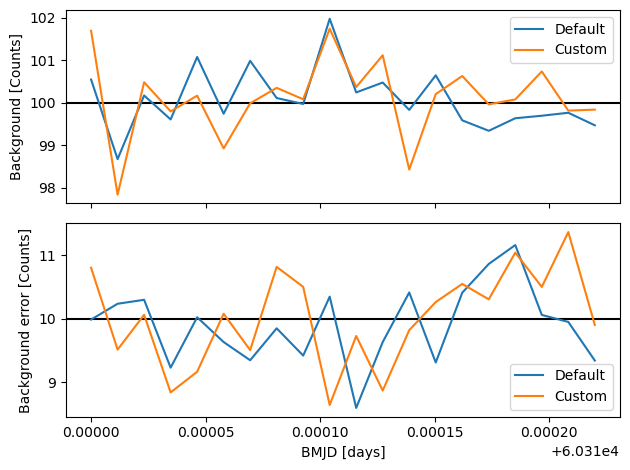

In [15]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(
    nrows=2,
    tight_layout=True,
    sharex=True,
    )

axes[0].plot(
    default_g_band_source_2_df['BMJD'],
    default_g_band_source_2_df['background'],
    label='Default',
)
axes[0].plot(
    custom_g_band_source_2_df['BMJD'],
    custom_g_band_source_2_df['background'],
    label='Custom',
)
axes[0].axhline(
    100,
    color='k',
    zorder=0,
)

axes[1].plot(
    default_g_band_source_2_df['BMJD'],
    default_g_band_source_2_df['background_err'],
    label='Default',
)
axes[1].plot(
    custom_g_band_source_2_df['BMJD'],
    custom_g_band_source_2_df['background_err'],
    label='Custom',
)
axes[1].axhline(
    10,
    color='k',
    zorder=0,
)

axes[1].set_xlabel('BMJD [days]')
axes[0].set_ylabel('Background [Counts]')
axes[1].set_ylabel('Background error [Counts]')

axes[0].legend()
axes[1].legend()

plt.show()

As we can see, both methods are around the expected values, and so either local background estimator would likely give pretty good results in practise.

That concludes the local background tutorial for `opticam_new`! The default local background estimator should be "good enough" in most cases, but we have seen how to implement custom local background estimators if required. Once again, I refer to the excellent `photutils` documentation for further details on implementing custom local background estimators: https://photutils.readthedocs.io/en/stable/user_guide/aperture.html#local-background-subtraction.